In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings


warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

## Task Step 2 - Find & Import Data Set

In [2]:
# Configure API key

quandl.ApiConfig.api_key = '9-uv_QH19p4QWB1r-CoV'

In [3]:
# Importing the Federal Reserve Economic Data "Personal Consumption Expenditures: Durable Goods" variable.
data = quandl.get('FRED/PCEDG')

In [5]:
data.head(5)

,Value
Date,
1959-01-01,42.3
1959-02-01,44.2
1959-03-01,44.4
1959-04-01,45.1
1959-05-01,45.4


In [6]:
data.shape 

(756, 1)

In [7]:
data.columns

Index(['Value'], dtype='object')

## Task Step 3 - Subset of data

The subset i will be taken will be between 2015 t0 2019, since this is the line with my dataset 

# Task Step 4 - Create a linechart

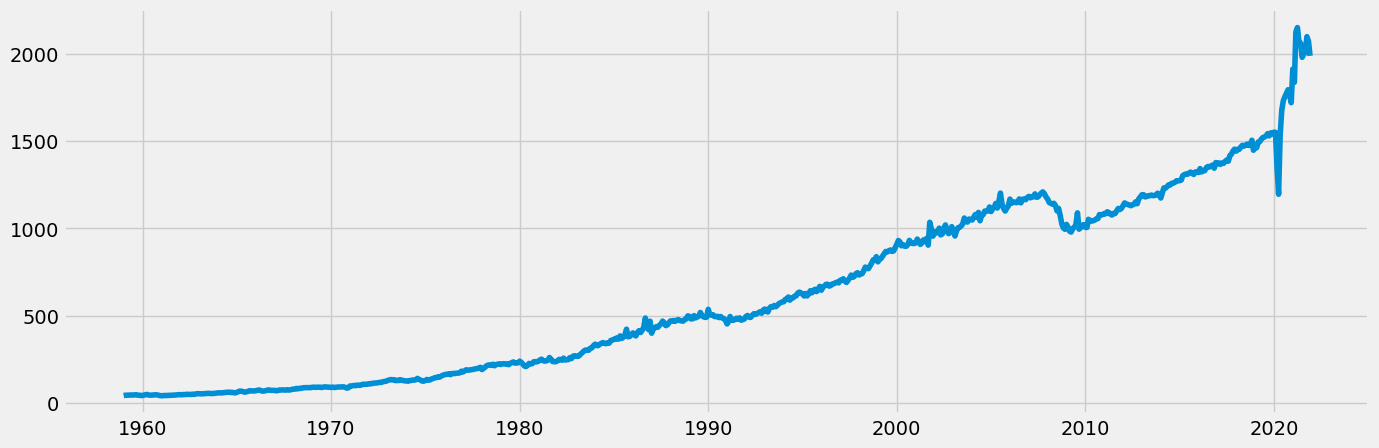

In [8]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

In [9]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [10]:
data_2.head()

,Date,Value
0,1959-01-01,42.3
1,1959-02-01,44.2
2,1959-03-01,44.4
3,1959-04-01,45.1
4,1959-05-01,45.4


In [13]:
# Subset of data
data_sub = data_2.loc[(data_2['Date'] >= '2015-01-01') & (data_2['Date'] < '2019-03-01')]

In [14]:
data_sub.head()

,Date,Value
672,2015-01-01,1273.3
673,2015-02-01,1276.7
674,2015-03-01,1301.4
675,2015-04-01,1307.8
676,2015-05-01,1311.3


In [15]:
data_sub.shape

(50, 2)

In [16]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
2015-01-01,1273.3
2015-02-01,1276.7
2015-03-01,1301.4
2015-04-01,1307.8
2015-05-01,1311.3


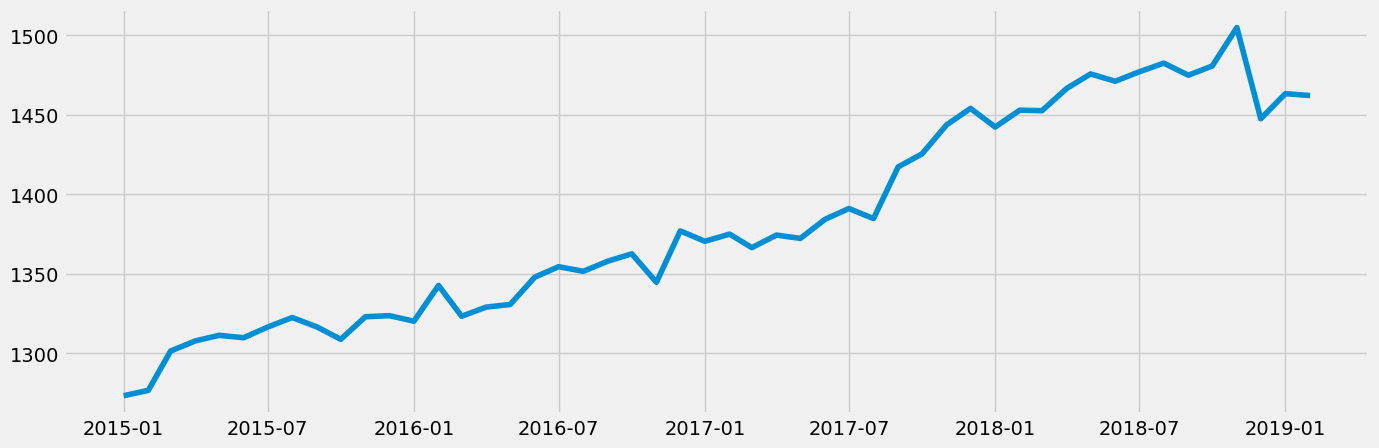

In [17]:
 #Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [18]:
# Check for missing values (you shouldn't have any)

data_sub.isnull().sum() 

Value    0
dtype: int64

In [19]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

# No dups!

0

## Task Step 5 - Decompose data components

In [20]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [21]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

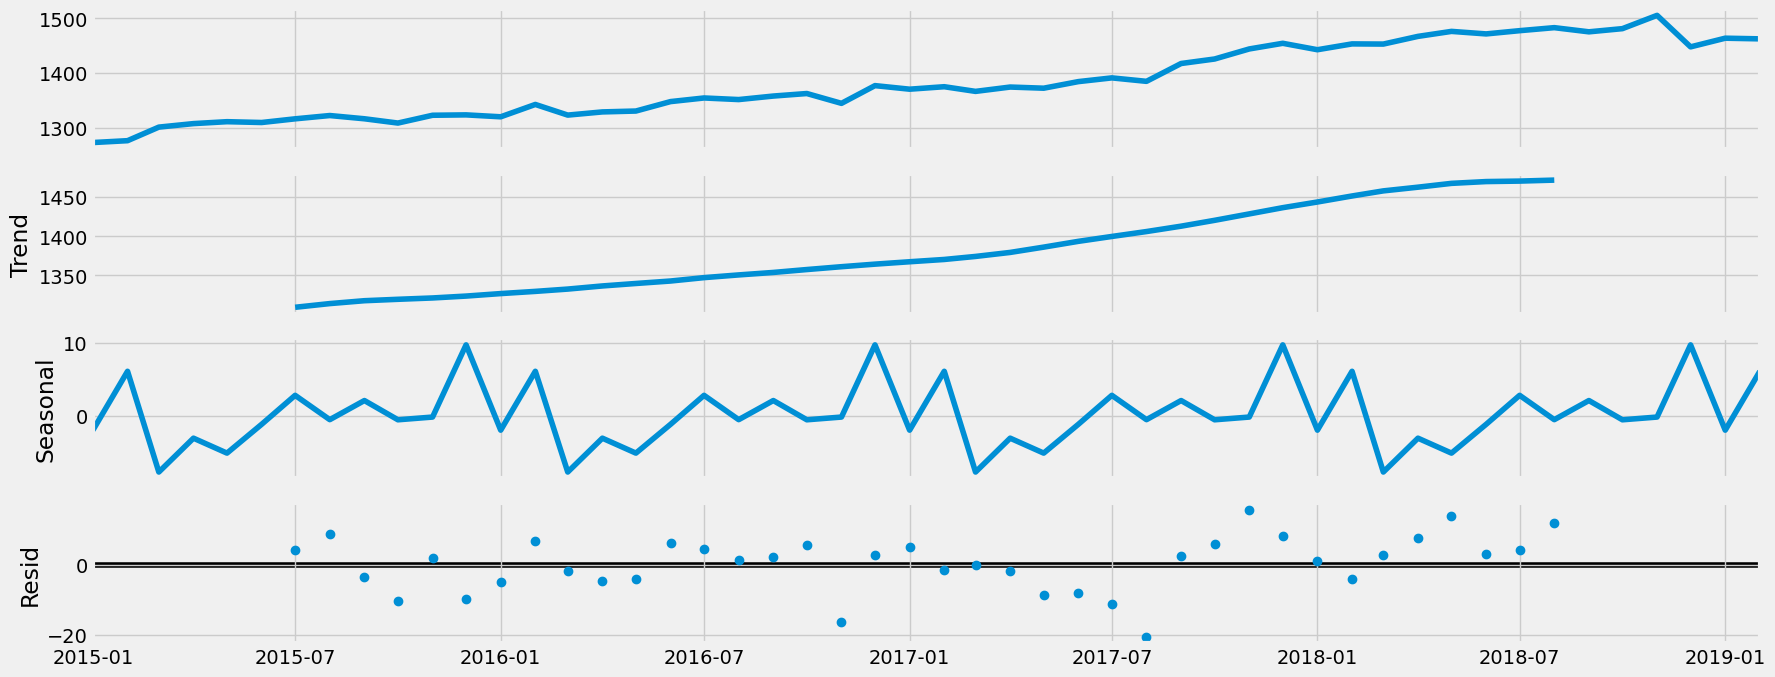

In [22]:
# Plot the separate components

decomposition.plot()
plt.show()


## Task Step 6 - Dickey-Fuller test

In [23]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                 -1.195368
p-value                         0.675585
Number of Lags Used             1.000000
Number of Observations Used    48.000000
Critical Value (1%)            -3.574589
Critical Value (5%)            -2.923954
Critical Value (10%)           -2.600039
dtype: float64


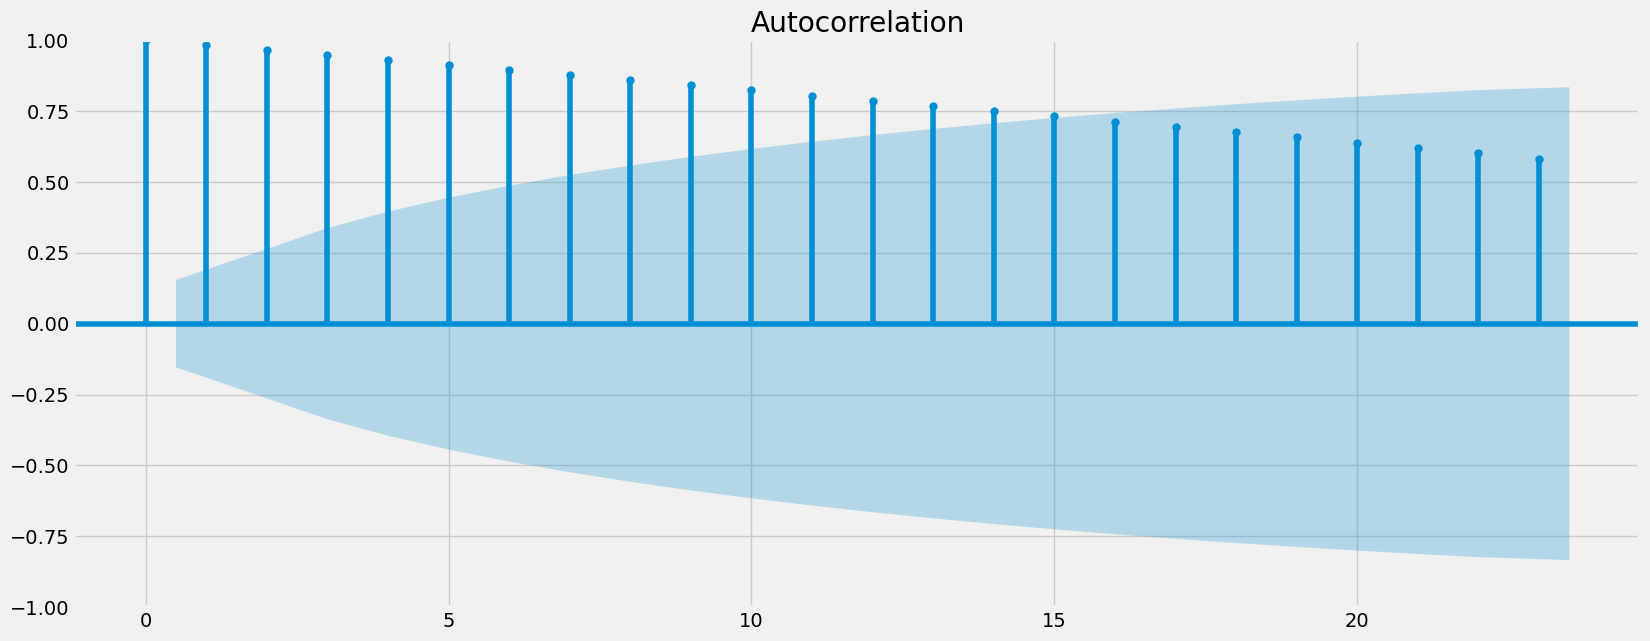

In [23]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

# Task Step 7 - Round of differencing

In [24]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [25]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [26]:
data_diff.head()

,Value
datetime,
2015-02-01,3.4
2015-03-01,24.7
2015-04-01,6.4
2015-05-01,3.5
2015-06-01,-1.5


In [27]:
data_diff.columns

Index(['Value'], dtype='object')

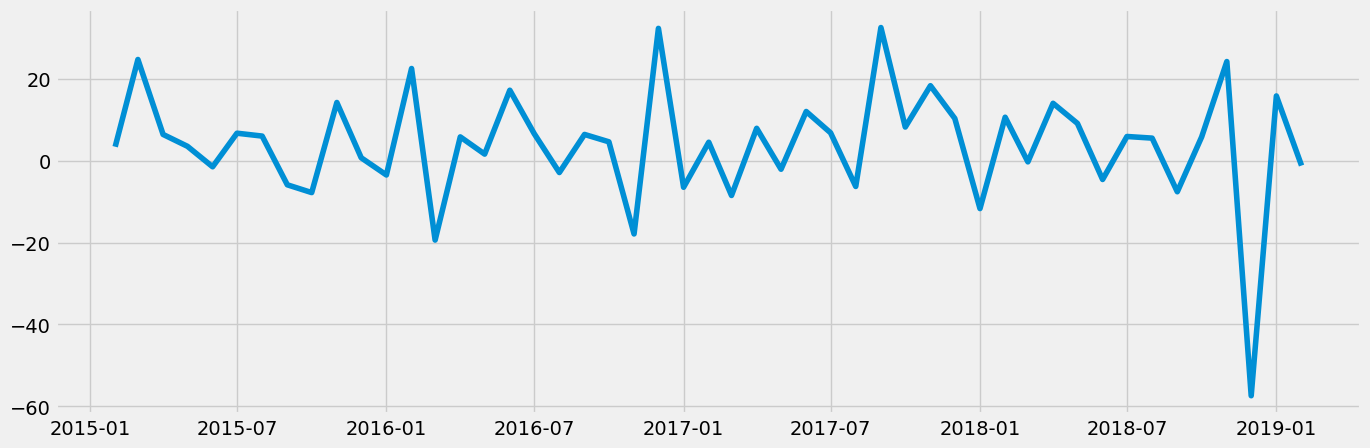

In [28]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [29]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -1.049251e+01
p-value                        1.137391e-18
Number of Lags Used            0.000000e+00
Number of Observations Used    4.800000e+01
Critical Value (1%)           -3.574589e+00
Critical Value (5%)           -2.923954e+00
Critical Value (10%)          -2.600039e+00
dtype: float64


# Task Step 8

The p-value is very low, this indicating that we should reject the null hypothesis of non-stationarity.
The test statistic is more extreme than the critical values, further supporting the rejection of the null hypothesis.
With a low p-value and a test statistic favoring stationarity, we have evidence to conclude that the time series is likely stationary.
In summary, based on the Dickey-Fuller test results, there is evidence to suggest that the time series is stationary. Stationarity is often a desirable property for time series analysis and modeling.

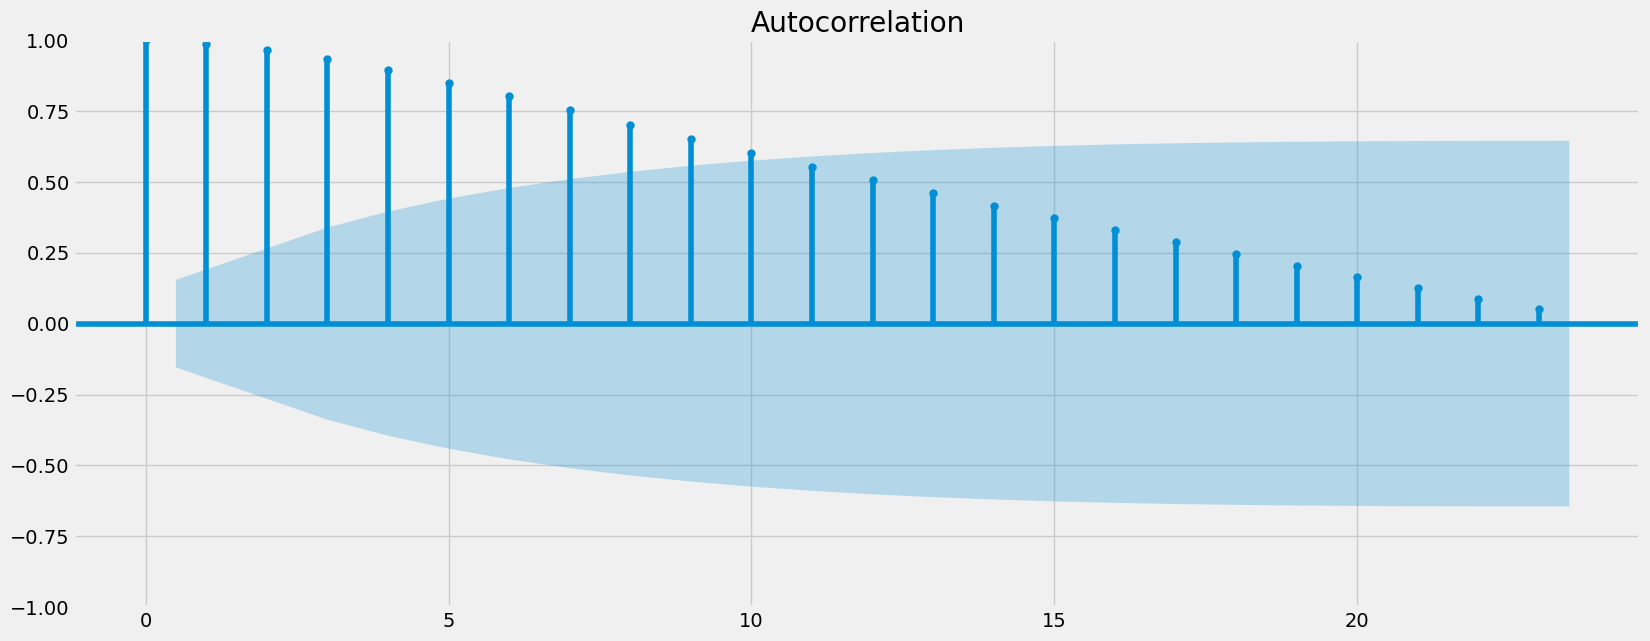

In [31]:
plot_acf(data_diff)
plt.show()

when there are no lags above the blue confidence interval, it generally suggests good alignment between predictions and actual values, with the model's uncertainty capturing the variability in the data appropriately. .